In [ ]:
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from typing import TypedDict
import subprocess
from openai import OpenAI
import textwrap
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
import operator
import base64

llm = init_chat_model("openai:gpt-4o-mini")


class State(TypedDict):

    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    final_summary: str

In [ ]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]
    subprocess.run(command)
    return {"audio_file": output_file}


def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="en",
            prompt="Carl Sagan, Voyager 1, pale blue dot, Oort Cloud, heliopause, interstellar medium, Alpha Centauri, Milky Way, Andromeda, Virgo Supercluster, Laniakea, Great Attractor, Local Group, astronomical unit, light year, megaparsec",
        )
    return {"transcription": transcription}


def dispatch_summarizer(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i + 1, "chunk": chunk})
    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):
    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    response = llm.invoke(
        f"""
               Please summarize the following text.
               
               Text: {chunk}
               """
    )

    summary = f"[Chunk {chunk_id}] {response.content}"
    return {"summaries": [summary]}


def mega_summary(state: State):
    all_summaries = "\n".join(state["summaries"])

    prompt = f"""
    You are given a multiple summaries of different chunks from a video transcription.
    
    Please create a comprehensive final summary that combines all the key points.
    
    Individual summaries:
    
    {all_summaries}

    """
    response = llm.invoke(prompt)
    return {"final_summary": response.content}


def dispatch_artists(state: State):
    return [
        Send("generate_thumbnails", {"id": i, "summary": state["final_summary"]})
        for i in [1, 2, 3, 4, 5]
    ]


def generate_thumbnails(args):
    concept_id = args["id"]
    summary = args["summary"]
    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.
    
    Create a detailed prompt for generating a thumbnail image that would attract viewers. Include:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition
    
    Summary: {summary}
    """

    response = llm.invoke(prompt)

    thumbnail_prompt = response.content

    client = OpenAI()

    result = client.images.generate(
        model="gpt-image-1",
        prompt=thumbnail_prompt,
        quality="low",
        moderation="low",
        size="auto",
    )

    image_bytes = base64.b64decode(result.data[0].b64_json)

    filename = f"thumbnail_{concept_id}.png"

    with open(filename, "wb") as file:
        file.write(image_bytes)

    return {"thumbnail_prompts": [thumbnail_prompt], "thumbnail_sketches": [filename]}

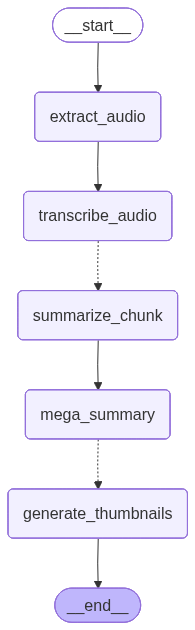

In [74]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)

graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizer, ["summarize_chunk"]
)
graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_conditional_edges(
    "mega_summary", dispatch_artists, ["generate_thumbnails"]
)
graph_builder.add_edge("generate_thumbnails", END)

graph = graph_builder.compile()

graph

In [75]:
graph.invoke({"video_file": "space.mp4"})

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.3.19.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --e

{'video_file': 'space.mp4',
 'audio_file': 'space.mp3',
 'transcription': "Earth, our home planet, a tiny blue dot floating in the immense cosmic ocean. Here resides everyone you ever knew, every human who ever lived, every story that was ever told. It's where our journey begins, but as we zoom out, beyond our atmosphere, past the moon, beyond the familiar planets and the sun, we embark on an epic quest, a quest to grasp the true scale of our universe. As we leave Earth's embrace, the first marker on our cosmic journey is the moon. About 384,400 km away, a distance so vast that if you were to drive a car at a constant speed of 100 km per hour, it would take you over 160 days to reach it. And from this lunar vantage point, Earth appears as a fragile sphere of blues and greens cradled in the black void of space, a sight that puts our existence into a humbling perspective. This is Earth as seen from the moon. As we continue our outward journey, the next milestone is the sun, lying approxi